In [74]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

from torchlake.common.metrics.classification import IncrementalConfusionMatrix
from torchlake.image_classification.models import ResNet50

# Setting

In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16

In [ ]:
artifact_path = Path("../data/resnet")
data_path = Path("../data/animal10")

In [ ]:
device = torch.device("cuda:0")

# data

In [76]:
preprocess = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)

In [77]:
dataset = torchvision.datasets.ImageFolder(
    data_path.as_posix(),
    transform=preprocess,
)

In [79]:
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

In [ ]:
num_class = len(dataset.classes)

# model

In [83]:
model = ResNet50(num_class).to(device)

# training

In [85]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())

In [86]:
epoches = 5
acc_iters = 64 // BATCH_SIZE

In [87]:
training_loss = []

model.train()
for e in range(epoches):
    running_loss = 0.0
    acc_iter = 0
    optim.zero_grad()
    
    for img, label in tqdm(train_loader):
        img = img.to(device)
        label = label.to(device)
        
        output = model(img)
        loss = criterion(output,label)
        loss /= acc_iters
        loss.backward()

        if acc_iter % acc_iters == 0:
            optim.step()
            optim.zero_grad()
            
        running_loss += loss.item()
        acc_iter += 1

    training_loss.append(running_loss/len(dataset))
    
    print(f'epoch {e+1}: {training_loss[e]}')

100%|██████████| 1636/1636 [04:49<00:00,  5.65it/s]


epoch 1: 0.0325866843069969


100%|██████████| 1636/1636 [04:48<00:00,  5.66it/s]


epoch 2: 0.02857320379220919


100%|██████████| 1636/1636 [04:50<00:00,  5.62it/s]


epoch 3: 0.0258126122315412


100%|██████████| 1636/1636 [04:59<00:00,  5.47it/s]


epoch 4: 0.023811753037105275


100%|██████████| 1636/1636 [04:48<00:00,  5.66it/s]

epoch 5: 0.0223105374975972


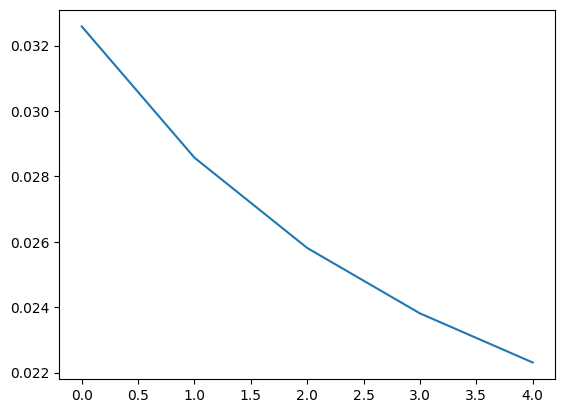

In [88]:
plt.plot(training_loss)

# inference

In [89]:
test_preprocess = transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

In [90]:
test_dataset = torchvision.datasets.ImageFolder(data_path.as_posix(), transform=test_preprocess)

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [91]:
confusion_matrix = IncrementalConfusionMatrix(num_class)

model.eval()
with torch.no_grad():
    for img, label in tqdm(test_loader):
        img = img.to(device)
        
        output = model(img)
        output = output.detach().cpu()

        output = output.argmax(dim=1)
        confusion_matrix.update(label, output)

100%|██████████| 26179/26179 [08:09<00:00, 53.54it/s]

0.5628175254975362


In [ ]:
print(confusion_matrix.diagonal() / confusion_matrix.sum(axis=0))

In [95]:
import requests
from io import BytesIO
import random

demo_url = "http://t2.gstatic.com/licensed-image?q=tbn:ANd9GcSFoiMCj_B7I2ML4tMYIbrcSgD9gBkp-G1JVfYz8R5xtL76jjcXyhY92BwcFNKCSxCU1NwmZ5XfIAO1VCF7WCM" # cow
# demo_url = "http://t0.gstatic.com/licensed-image?q=tbn:ANd9GcRgs4mxH44aRwV3qnlSmBlnP2u4pEDu8gatItCeqvXEb3yUol302ClE9ujMszbxXiyPZopDy-3i9EzcjjLNdTI" # horse
img = Image.open(BytesIO(requests.get(demo_url).content))
img = test_preprocess(img).unsqueeze(0).to(device)

# idx = random.randint(0, len(dataset))
# sample = test_dataset[idx]
# img = sample[0].unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    prediction = model(img).detach().cpu()
    print(dataset.classes[prediction.argmax()])
    # print(dataset.classes[sample[1]])

cane


In [ ]:
model_path = artifact_path / 'resnet.pth'

In [96]:
torch.save(model, model_path)

In [97]:
model_path.stat().st_size / 1024**2

90.10343742370605

In [9]:
model = torch.load(model_path.as_posix())

In [22]:
# Netron 檢查
onnx_path = artifact_path / "resnet.onnx"
torch.onnx.export(model.cpu(), torch.randn(1, 3, 224, 224), onnx_path.as_posix())